# 3. Entrenamiento del modelo de regresión
In this notebook the best indicators and selected, companied by the categorical variables in order to train a Regression model.

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split

from scripts import univariate_utils, multivariate_utils

from itertools import combinations

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import r2_score

## Constants

In [2]:
LOADING_FILE_PATH = "data/gapminder_clean.parquet"

In [3]:
TARGET_VARIABLE = "incomeperperson"
ID_COLUMN = "country"

In [4]:
RANDOM_STATE = 42

In [5]:
TEST_SIZE = 0.3

In [6]:
HIGH_CORR = 0.9

In [7]:
LOG_EPSILON = 1e-7

## Utils

In [8]:
def col_to_dummies(X_data, col, prefix, encoder=None):
    """Fits or uses a encoder to generate dummies for a column"""
    trans_values = X_data[col].values.reshape(-1, 1)
    if encoder is None:
        encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
        encoder.fit(trans_values)
        trans_data = encoder.transform(trans_values)
    else:
        trans_data = encoder.transform(trans_values)
    
    cat_cols = [
        cat.replace("x0", col) for cat in encoder.get_feature_names_out()
    ]   

    X_data.drop(columns=col, inplace=True)
    X_data[cat_cols] = trans_data
    
    if encoder is None:
        return encoder
    return

## Execution

### Load data

In [9]:
df_pib = pd.read_parquet(LOADING_FILE_PATH)

### Separing columns by their types

In [10]:
NUMERICAL_COLUMNS = [
    col for col in
    df_pib.select_dtypes(include=np.number).columns.tolist()
    if col != TARGET_VARIABLE
]
CATEGORICAL_COLUMNS = [
    col for col in
    df_pib.select_dtypes(include="O").columns.tolist()
    if col != ID_COLUMN
]
BOOLEAN_COLUMNS = [
    col for col in df_pib.columns if col not in
    NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS + [ID_COLUMN, TARGET_VARIABLE]
]

FEATURE_COLUMNS = [col for col in df_pib.columns if col not in [ID_COLUMN, TARGET_VARIABLE]]

In [11]:
NUMERICAL_COLUMNS

['alcconsumption',
 'armedforcesrate',
 'breastcancerper100th',
 'co2emissions',
 'femaleemployrate',
 'internetuserate',
 'lifeexpectancy',
 'polityscore',
 'suicideper100th',
 'employrate',
 'urbanrate',
 'area']

In [12]:
CATEGORICAL_COLUMNS

['region', 'subregion']

In [13]:
BOOLEAN_COLUMNS

['independent', 'landlocked', 'is_developed']

In [14]:
FEATURE_COLUMNS

['alcconsumption',
 'armedforcesrate',
 'breastcancerper100th',
 'co2emissions',
 'femaleemployrate',
 'internetuserate',
 'lifeexpectancy',
 'polityscore',
 'suicideper100th',
 'employrate',
 'urbanrate',
 'independent',
 'region',
 'subregion',
 'landlocked',
 'area',
 'is_developed']

### Train test split

In [15]:
df_pib.index = df_pib["country"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df_pib[FEATURE_COLUMNS],
    df_pib[TARGET_VARIABLE],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_pib["region"]
)

In [17]:
X_train.shape, len(FEATURE_COLUMNS)

((116, 17), 17)

### Colineality overview
Variables with high correlation are removed. In fact absolute correlations over 0.9 are checked to remove variables.

- femaleemployrate has a correlation of 0.85 with employrate, but as femaleemployrate may represent social factors in country development, it is kept and employrate is dropped instead. There are not correlations with higher absolute value than this one.

<Axes: >

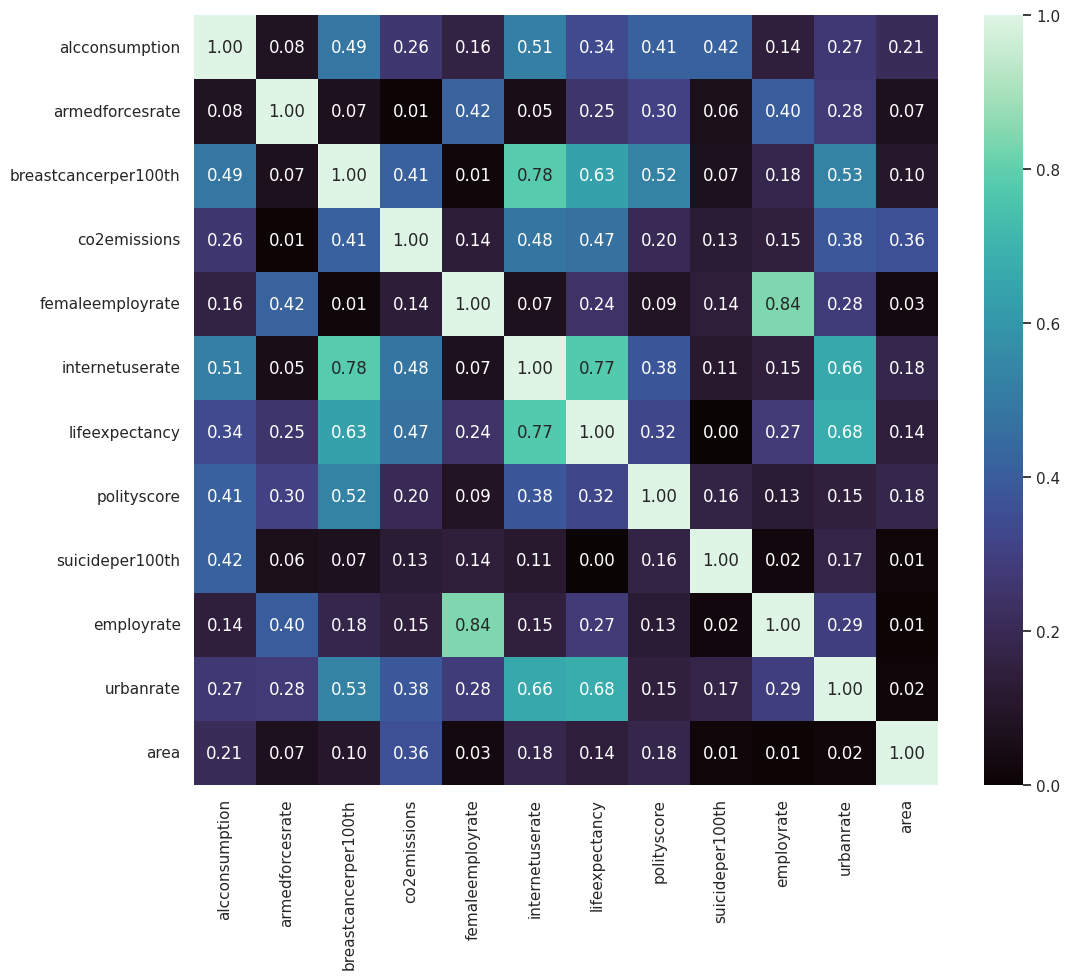

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train[NUMERICAL_COLUMNS].corr().abs(), cmap="mako", vmin=0, vmax=1, annot=True, fmt=".2f")

In [19]:
relevant_corrs = []
for col1, col2 in combinations(NUMERICAL_COLUMNS, 2):
    df_corr = multivariate_utils.test_correlation(
      df_pib,
      col1,
      col2,
      "pearson",
      0.05
    )
    if df_corr["statistic"].abs().tolist()[0] >= 0.20:
        relevant_corrs.append(df_corr)
df_relevant_corrs = pd.concat(relevant_corrs)

In [20]:
df_relevant_corrs[df_relevant_corrs["statistic"].abs() >= 0.7].sort_values("statistic")

,value_col1,value_col2,test,statistic,pvalue,dependent
0,internetuserate,lifeexpectancy,pearson,0.772094,4.133157e-34,True
0,breastcancerper100th,internetuserate,pearson,0.789209,1.476061e-36,True
0,femaleemployrate,employrate,pearson,0.856718,5.069087e-49,True


In [21]:
df_pib.drop(columns="employrate", inplace=True)

### Lineality check

Polinomial transformation is avoided in order to interpret the results easily. From the graphics is quite difficult to determine if the relations are linear, because data is not concentrated on a linear trend with low variance.

#### Base correlations
Some variables do not have significant correlation with the output variable in their original shape.

In [22]:
df_train = pd.DataFrame(
    X_train,
    columns=FEATURE_COLUMNS
)
df_train[TARGET_VARIABLE] = y_train.values

In [23]:
df_corr_with_target = (
    df_train[[TARGET_VARIABLE] + NUMERICAL_COLUMNS]
    .corr()
    .iloc[0]
    .to_frame(name="correlation_with_incomeperperson")
)

In [24]:
df_corr_with_target

,correlation_with_incomeperperson
incomeperperson,1.000000
alcconsumption,0.278083
armedforcesrate,0.041602
breastcancerper100th,0.729911
co2emissions,0.481693
femaleemployrate,-0.001502
internetuserate,0.842246
lifeexpectancy,0.652321
polityscore,0.270522
suicideper100th,0.004073


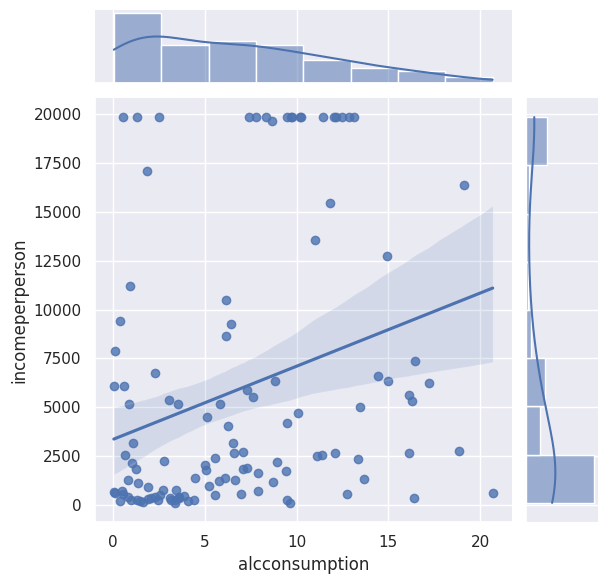

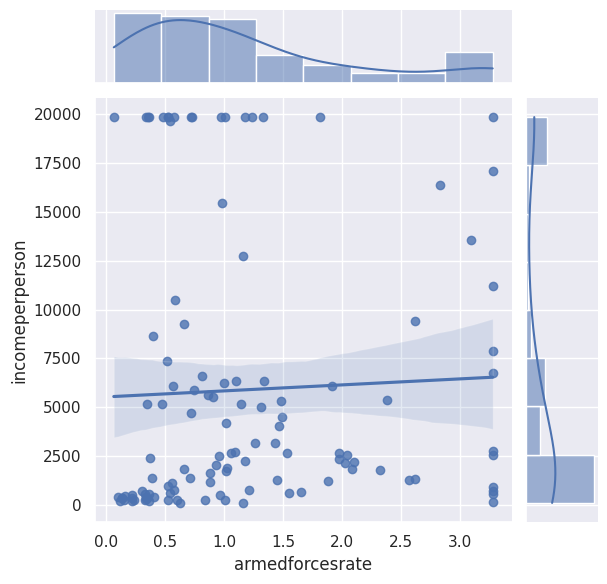

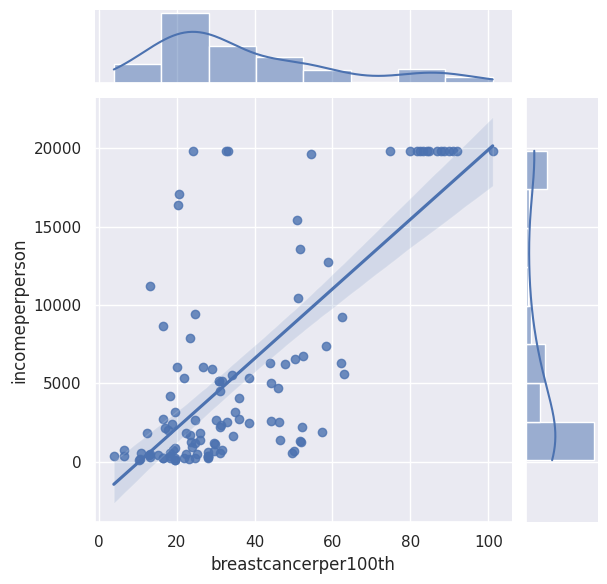

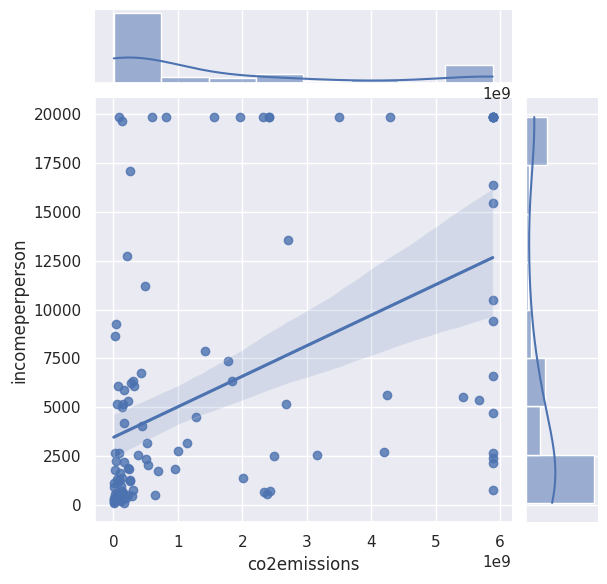

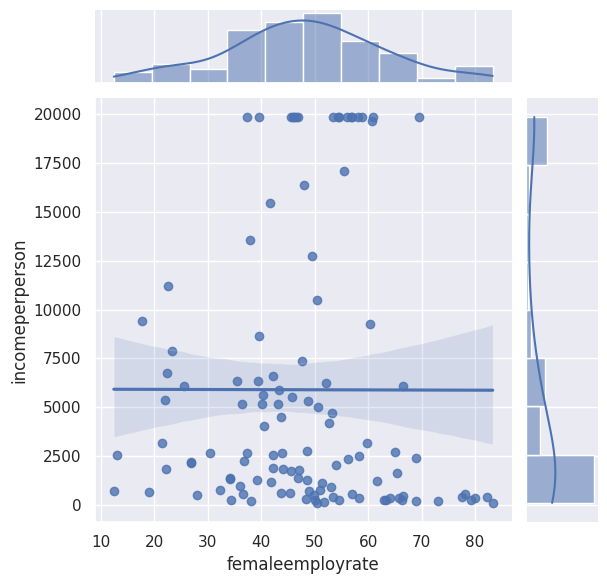

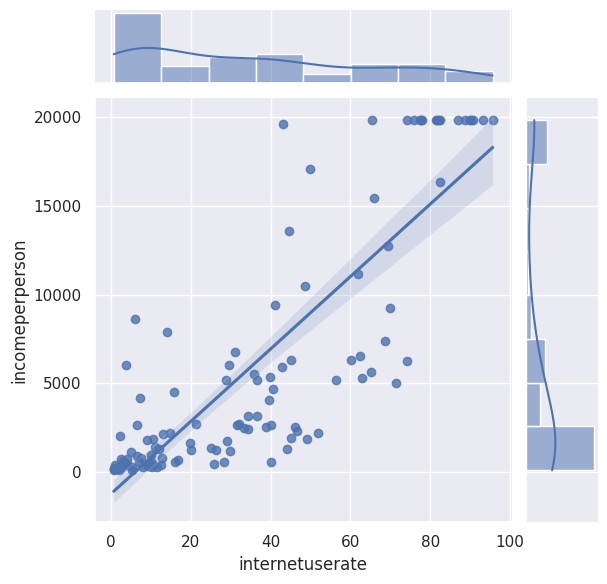

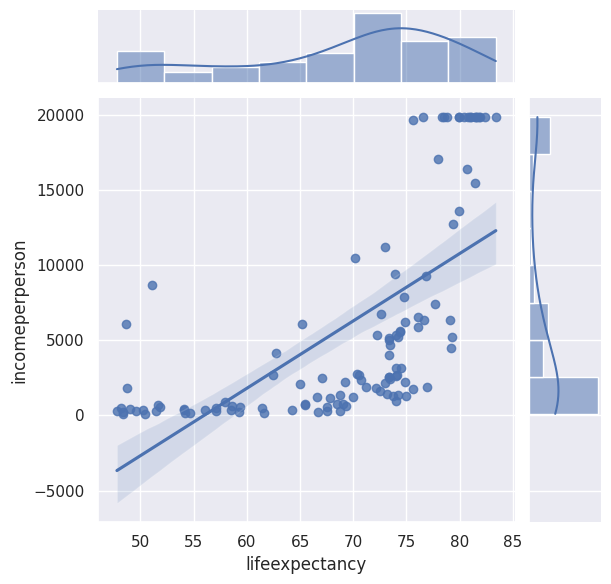

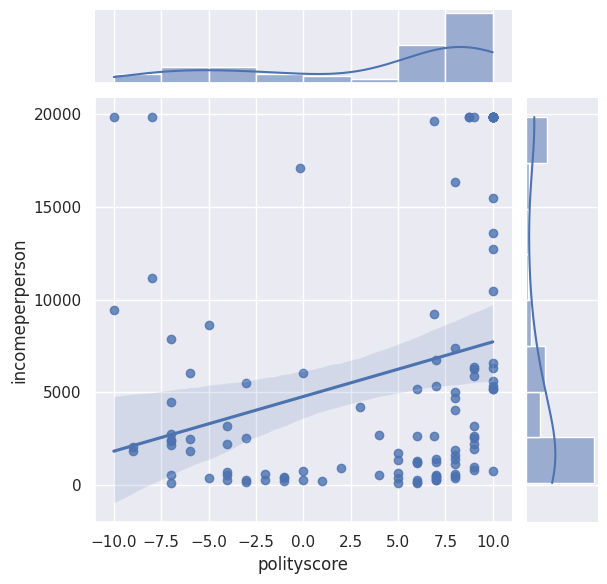

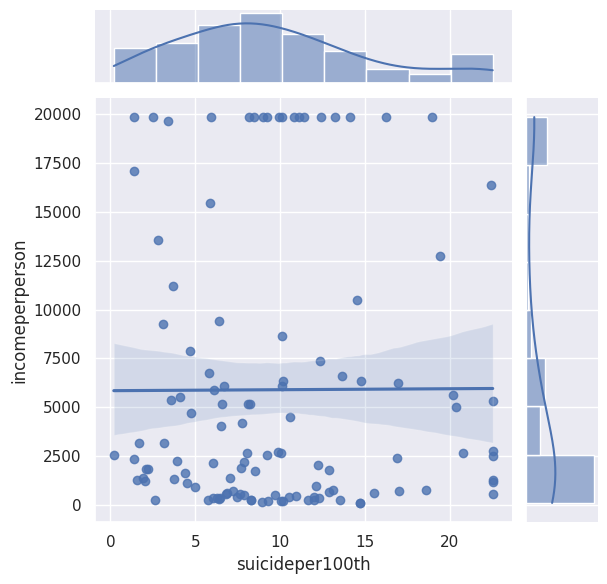

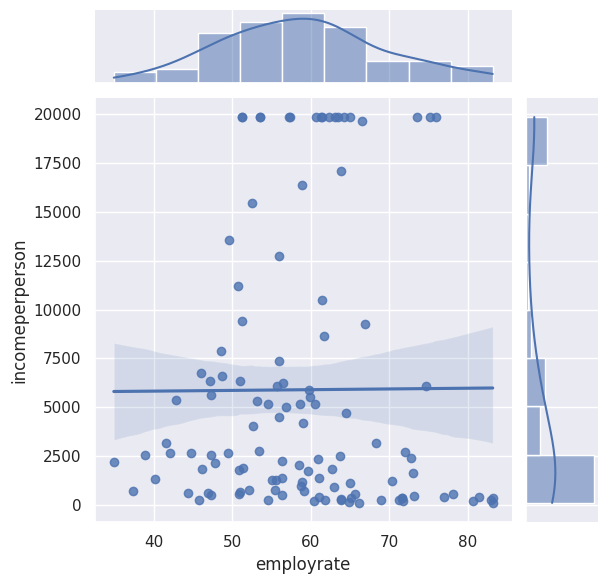

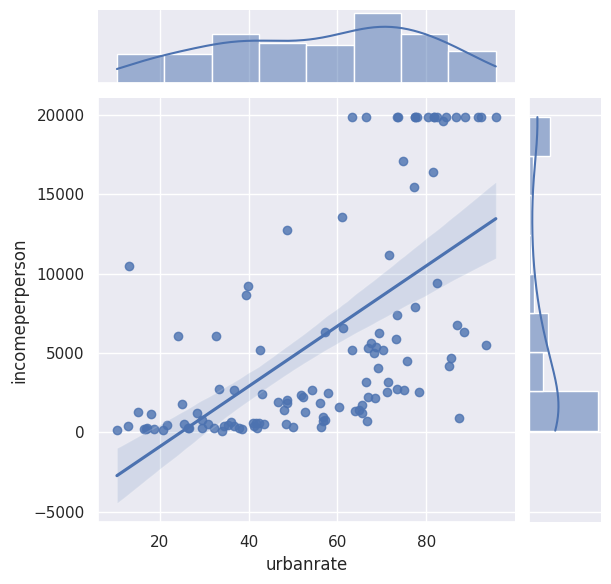

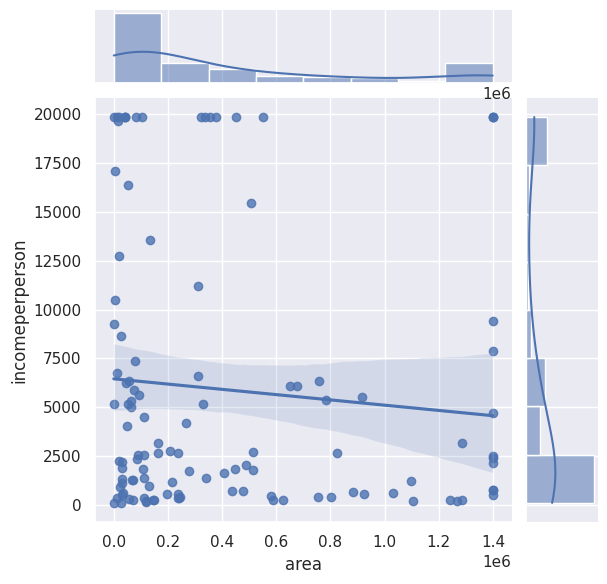

In [25]:
for col in NUMERICAL_COLUMNS:
    sns.jointplot(
        data=df_train,
        y=TARGET_VARIABLE,
        x=col,
        kind="reg"
    )

#### Base correlations with log transformation

In [26]:
df_train_log = df_train.copy(deep=True)

In [27]:
for col in NUMERICAL_COLUMNS:
    df_train_log[col] = np.log(df_train_log[col] + LOG_EPSILON)

/home/johan/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
df_corr_with_target_log = (
    df_train_log[[TARGET_VARIABLE] + NUMERICAL_COLUMNS]
    .corr()
    .iloc[0]
    .to_frame(name="correlation_with_incomeperperson_log")
)

In [29]:
df_corr_with_target_log

,correlation_with_incomeperperson_log
incomeperperson,1.000000
alcconsumption,0.222649
armedforcesrate,0.070949
breastcancerper100th,0.625371
co2emissions,0.517540
femaleemployrate,0.047113
internetuserate,0.660052
lifeexpectancy,0.614271
polityscore,0.161690
suicideper100th,0.001721


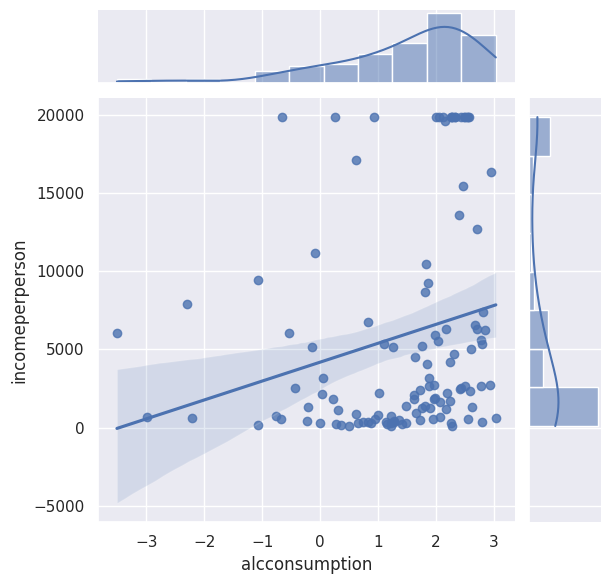

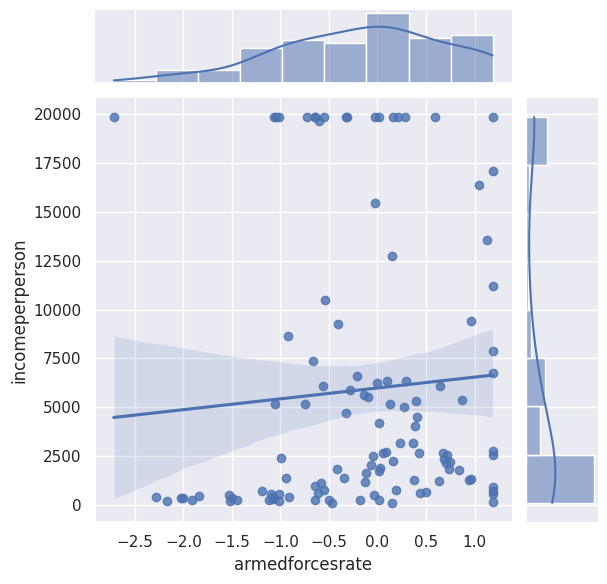

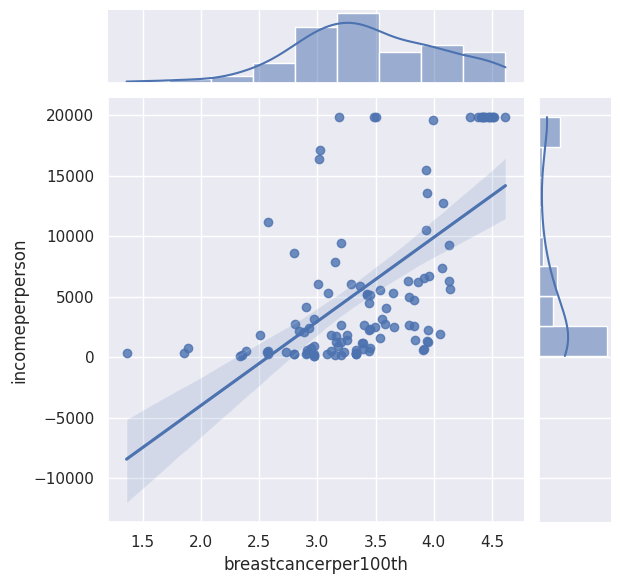

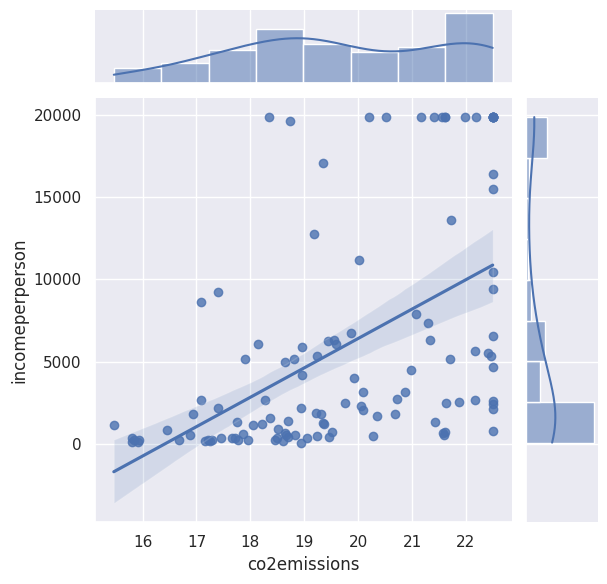

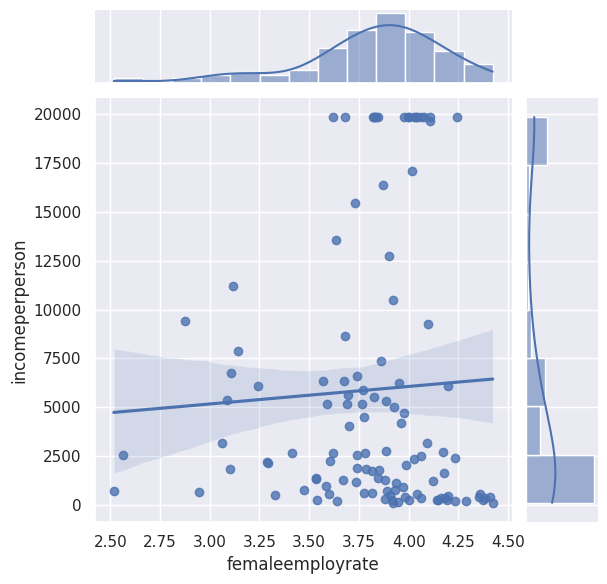

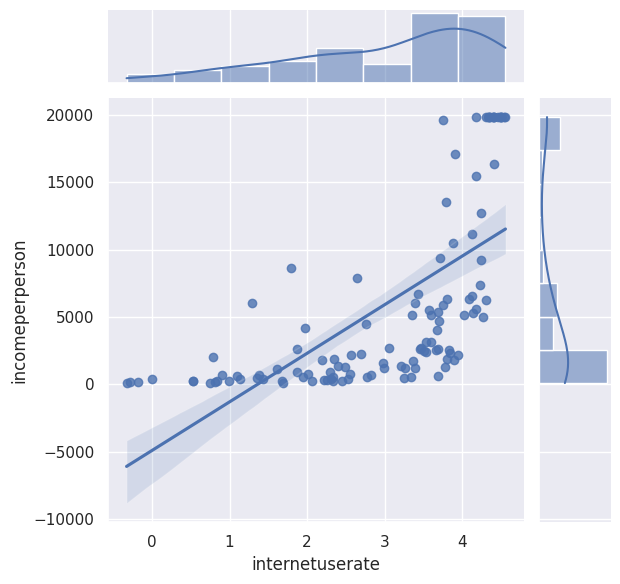

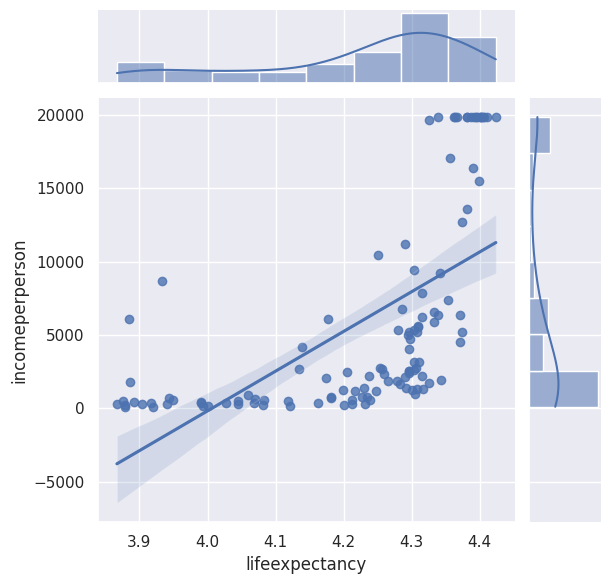

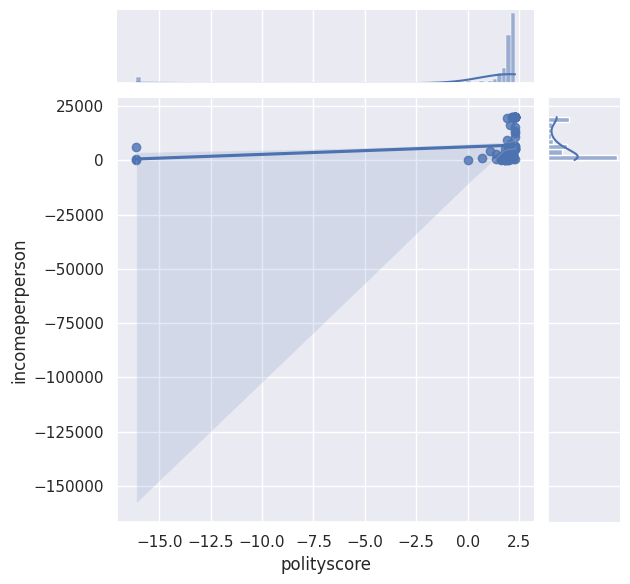

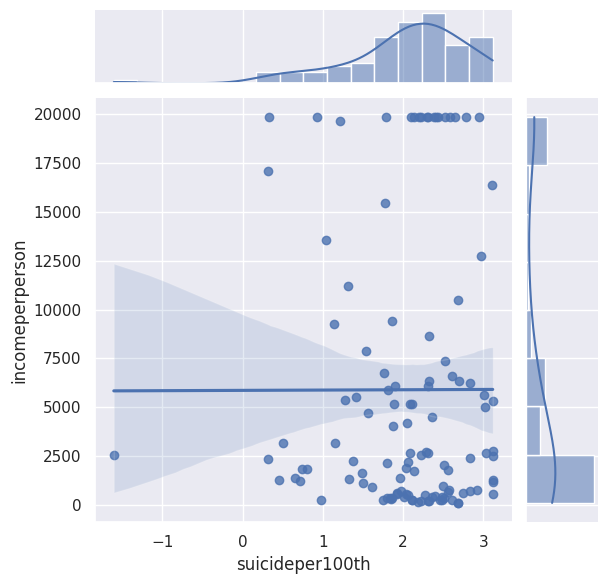

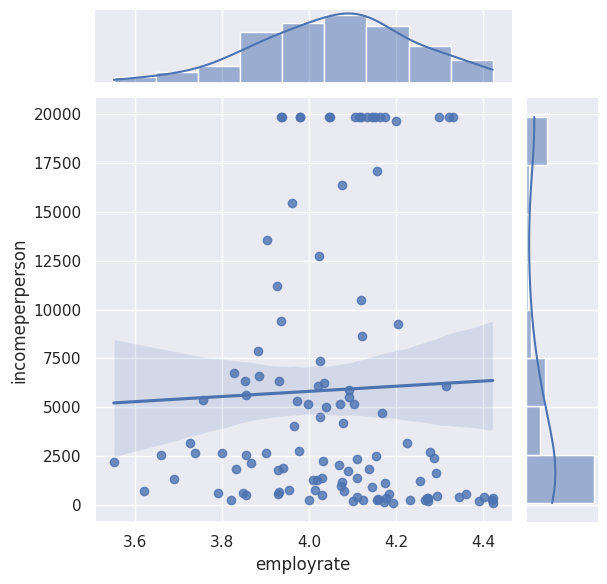

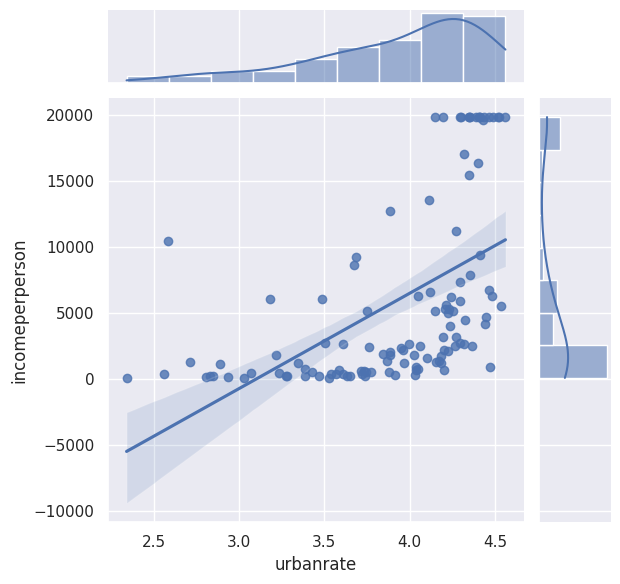

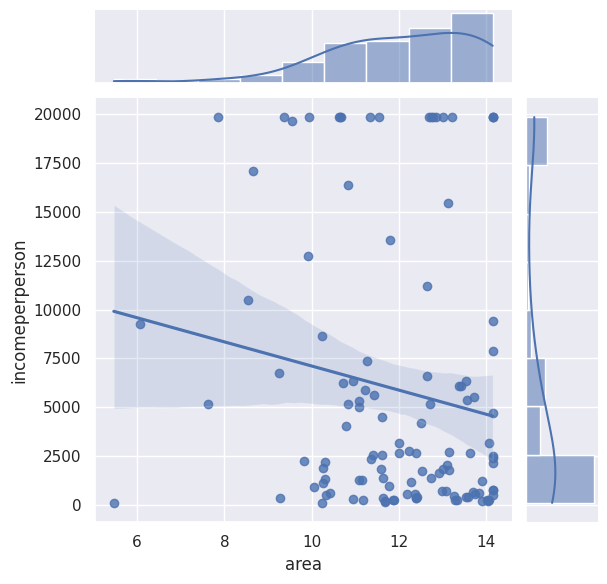

In [30]:
for col in NUMERICAL_COLUMNS:
    sns.jointplot(
        data=df_train_log,
        y=TARGET_VARIABLE,
        x=col,
        kind="reg"
    )

### Checking improvements of log transformation
- We can see correlations for co2emissions increased by double its value.
- As the domain of polityscore has negative values, this transformation would fill the column of nulls.

In [31]:
df_corr_target_comparison = df_corr_with_target.join(df_corr_with_target_log)

In [32]:
df_corr_target_comparison[
    df_corr_target_comparison["correlation_with_incomeperperson"]
    <= df_corr_target_comparison["correlation_with_incomeperperson_log"]
]

,correlation_with_incomeperperson,correlation_with_incomeperperson_log
incomeperperson,1.000000,1.000000
armedforcesrate,0.041602,0.070949
co2emissions,0.481693,0.517540
femaleemployrate,-0.001502,0.047113
employrate,0.005576,0.034162


### Transforming co2emissions and polityscore to log scale

In [33]:
X_train["co2emissions"] = np.log(X_train["co2emissions"] + LOG_EPSILON)
X_test["co2emissions"] = np.log(X_test["co2emissions"] + LOG_EPSILON)
df_train["co2emissions"] = np.log(df_train["co2emissions"] + LOG_EPSILON)

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, Australia to Peru
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alcconsumption        116 non-null    float64
 1   armedforcesrate       116 non-null    float64
 2   breastcancerper100th  116 non-null    float64
 3   co2emissions          116 non-null    float64
 4   femaleemployrate      116 non-null    float64
 5   internetuserate       116 non-null    float64
 6   lifeexpectancy        116 non-null    float64
 7   polityscore           116 non-null    float64
 8   suicideper100th       116 non-null    float64
 9   employrate            116 non-null    float64
 10  urbanrate             116 non-null    float64
 11  independent           116 non-null    bool   
 12  region                116 non-null    object 
 13  subregion             116 non-null    object 
 14  landlocked            116 non-null    bool   
 15  area               

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Russia to Haiti
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alcconsumption        50 non-null     float64
 1   armedforcesrate       50 non-null     float64
 2   breastcancerper100th  50 non-null     float64
 3   co2emissions          50 non-null     float64
 4   femaleemployrate      50 non-null     float64
 5   internetuserate       50 non-null     float64
 6   lifeexpectancy        50 non-null     float64
 7   polityscore           50 non-null     float64
 8   suicideper100th       50 non-null     float64
 9   employrate            50 non-null     float64
 10  urbanrate             50 non-null     float64
 11  independent           50 non-null     bool   
 12  region                50 non-null     object 
 13  subregion             50 non-null     object 
 14  landlocked            50 non-null     bool   
 15  area                  

### Selection of numerical variables
Variables with weak (0.2) or better absolute correlation are selected for the model. The rest is dropped.

In [36]:
df_corr_target_comparison[
    (
        df_corr_target_comparison["correlation_with_incomeperperson"].abs() >= 0.2
    )
    | (
        df_corr_target_comparison["correlation_with_incomeperperson_log"].abs() >= 0.2
    )
]

,correlation_with_incomeperperson,correlation_with_incomeperperson_log
incomeperperson,1.000000,1.000000
alcconsumption,0.278083,0.222649
breastcancerper100th,0.729911,0.625371
co2emissions,0.481693,0.517540
internetuserate,0.842246,0.660052
lifeexpectancy,0.652321,0.614271
polityscore,0.270522,0.161690
urbanrate,0.614262,0.529193


In [37]:
SELECTED_NUMERICAL_COLUMNS = [
    "alcconsumption",
    "breastcancerper100th",
    "co2emissions",
    "internetuserate",
    "lifeexpectancy",
    "polityscore",
    "urbanrate"
]
DROPPED_NUMERICAL_COLUMNS = [
    col for col in NUMERICAL_COLUMNS
    if col not in SELECTED_NUMERICAL_COLUMNS
]
NUMERICAL_COLUMNS = SELECTED_NUMERICAL_COLUMNS

In [38]:
X_train.drop(columns=DROPPED_NUMERICAL_COLUMNS, inplace=True)
X_test.drop(columns=DROPPED_NUMERICAL_COLUMNS, inplace=True)
df_train.drop(columns=DROPPED_NUMERICAL_COLUMNS, inplace=True)

### Error normality for numerical variables
A linear scaler is fit to check if errors behave normally. According to the qq-plot they seem behave normally.

In [39]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [40]:
pipeline.fit(X_train[NUMERICAL_COLUMNS], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [41]:
errors = (pipeline.predict(X_train[NUMERICAL_COLUMNS])-y_train).values

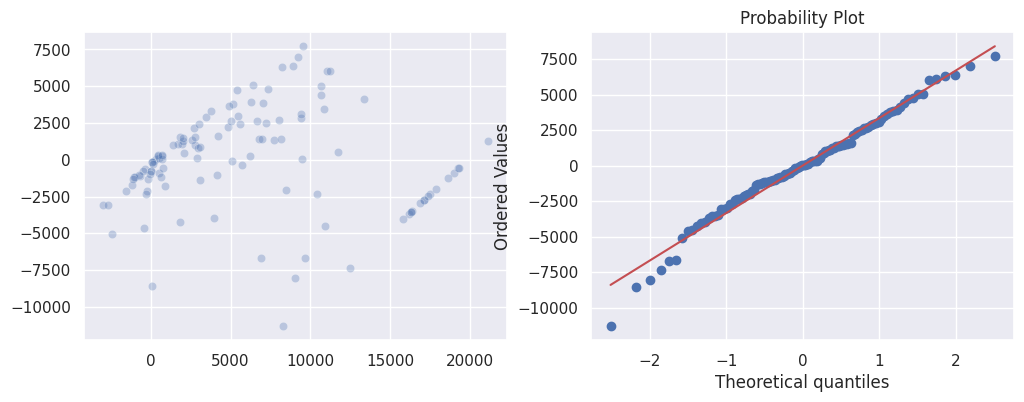

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=pipeline.predict(X_train[NUMERICAL_COLUMNS]), y=errors, alpha=0.3, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

### Homoscedasticity for numerical variables
Variance of errors seems to be evenly dispersed over -7500 and 7500 with no shifts. However, they might not be enough data for larger values of income.

<Axes: >

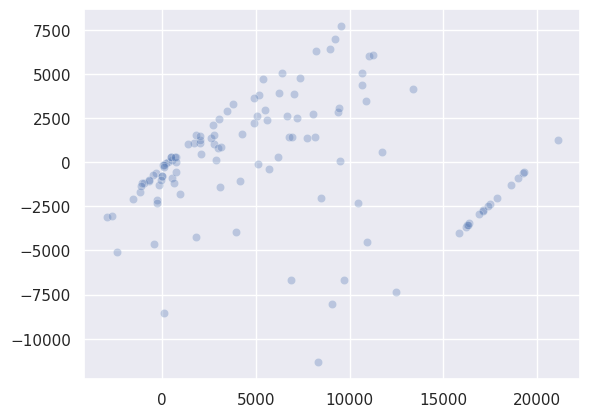

In [43]:
sns.scatterplot(x = pipeline.predict(X_train[NUMERICAL_COLUMNS]), y=errors, alpha=0.3)

### Categorical variable transformation

Subregion is highly dimensional. But it is kept to check if it can be used for the model to detect special regions.

In [44]:
for col in CATEGORICAL_COLUMNS:
    print(col, X_train[col].nunique())
    display(X_train[col].value_counts().to_frame(name=f"count__{col}"))

region 5


,count__region
region,
Africa,33
Asia,32
Europe,25
Americas,22
Oceania,4


subregion 23


,count__subregion
subregion,
Western Asia,13
Western Africa,11
Eastern Africa,11
South America,9
Northern Europe,8
South-Eastern Asia,7
Southern Asia,6
Central America,6
Middle Africa,5


In [45]:
for col in BOOLEAN_COLUMNS:
    display(X_train[col].value_counts().to_frame(name=f"count__{col}"))

,count__independent
independent,
True,115
False,1


,count__landlocked
landlocked,
False,88
True,28


,count__is_developed
is_developed,
False,74
True,42


In [46]:
X_train[BOOLEAN_COLUMNS].describe()

,independent,landlocked,is_developed
count,116,116,116
unique,2,2,2
top,True,False,False
freq,115,88,74


#### One hot encoding
One hot encoding because it is highly interpretable.

In [47]:
region_encoder = col_to_dummies(
    X_train,
    "region",
    "region",
    None
)

/home/johan/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [48]:
col_to_dummies(
    X_test,
    "region",
    "region",
    region_encoder
)

/home/johan/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
subregion_encoder = col_to_dummies(
    X_train,
    "subregion",
    "subregion",
    None
)

/home/johan/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [50]:
col_to_dummies(
    X_test,
    "subregion",
    "subregion",
    subregion_encoder
)

/home/johan/.local/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Error normality for all variables
A linear scaler is fit to check if errors behave normally. According to the qq-plot they seem behave normally.

In [51]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [52]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [53]:
errors = (pipeline.predict(X_train)-y_train).values

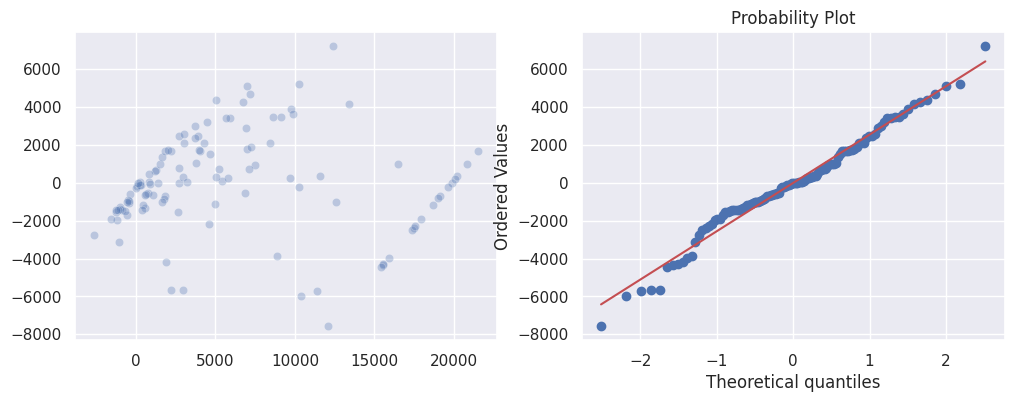

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Dispersión
sns.scatterplot(x=pipeline.predict(X_train), y=errors, alpha=0.3, ax=axes[0])

# q-q plot
_ = stats.probplot(errors, dist="norm", plot=axes[1])

### Homoscedasticity for numerical variables
Variance of errors seems to be evenly dispersed over -6000 and 6000 with no shifts. However, they might not be enough data for larger values of income.

<Axes: >

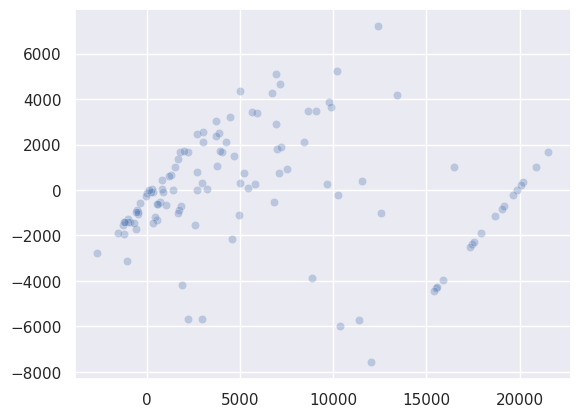

In [55]:
sns.scatterplot(x = pipeline.predict(X_train), y=errors, alpha=0.3)

### Model training
The pipeline with standard scaler is not used because it makes it difficult to interpret "co2emissions", because it has a log transformation before.

In [56]:
model = LinearRegression()

#### Removal of unique categories from train not in test and viceversa

In [57]:
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)
FINAL_FEATURES = sorted(list((train_cols) & set(test_cols)))

In [58]:
X_train = X_train[FINAL_FEATURES]
X_test = X_test[FINAL_FEATURES]

#### Scaling columns without log transform

In [59]:
no_log_cols = [
    col for col in FINAL_FEATURES
    if (col != "co2emissions")
    and "region" not in col
]

In [60]:
SCALER = StandardScaler()
X_train[no_log_cols] = SCALER.fit_transform(X_train[no_log_cols])
X_test[no_log_cols] = SCALER.transform(X_test[no_log_cols])

In [61]:
model.fit(X_train, y_train)

LinearRegression()

### Metrics
Although some correlations with the target variable are high, such as internetuserate, the error is really high, being close to the median of the target variable value for the population. This means that it is possible that a more complex is needed for the problem, including:
- More fine grained data.
- More features.
- A model with more parameters.

Although the r2 metrics gets a very good value.

In [62]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, model.predict(X_train)))
print("Test:", mean_absolute_error(y_test, model.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, model.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
print("\nR2:")
print("Train:", np.sqrt(r2_score(y_train, model.predict(X_train))))
print("Test:", np.sqrt(r2_score(y_test, model.predict(X_test))))

MAE:
Train: 1892.5406275875068
Test: 2008.0442233005288

RMSE:
Train: 2531.954556483762
Test: 2945.9141498541517

R2:
Train: 0.9307237563773677
Test: 0.8949861635682271


In [63]:
df_pib["incomeperperson"].describe()

count      166.000000
mean      5759.015509
std       6852.459761
min        103.775857
25%        609.437746
50%       2453.595106
75%       8305.512026
max      19849.623446
Name: incomeperperson, dtype: float64

### Coefficients and intercept
- As all transformations were by Z-score except one, the expected value of the income when all variables are at their mean is $6548 USD.

#### Numerical variables
For some of the variables, it seems that the model assigns negative scores in order to diminish the error without taking into account correlations, such as lifeexpectancy.

- An increase of 28.66 in internetuserate implies an increase of \$4864.82 USD in GDP.
- An increase of 36.88 in breastcancerper100th implies an increase of \$1895.46 USD in GDP.
- An increase of 5.16 in alcconsumption implies a decrease of \$1223 USD in GDP.
- An increase of 6.37 in polityscore implies a decrease of \$1003.56 USD in GDP. This result is quite unexpected, because more democratical countries are supposed to have better economies.
- An increase of 22.49 in urbanrate implies an increase of \$820.53 USD in GDP.
- An increase of 10.11 in lifeexpectancy implies a decrease of \$231.97 USD in GDP. As the result of polityscore, this is unexpected.
- An increase of 2.01 emissions implies a decrease of $-33.24 USD in GDP.

#### Categorical variables
- Being developed translates into a very higher GDP.
- Being landlocked translates into a very higher GDP, although Switzerland is in the results, and it can increase the GDP statistics for the group.
- Countries from Southern Europe or Southern Europe tend to have the highest GDP, while countries from Western Asia and Northern Africa have the opposite conditions.

In [64]:
model.intercept_

7617.508407611209

In [65]:
df_coefs = pd.DataFrame({"column": X_train.columns, "coef": model.coef_})

In [66]:
df_coefs["abs_coef"] = df_coefs["coef"].abs()

#### Numerical variables

In [67]:
df_train[NUMERICAL_COLUMNS].describe()

,alcconsumption,breastcancerper100th,co2emissions,internetuserate,lifeexpectancy,polityscore,urbanrate
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,6.777144,36.885345,19.705412,34.869501,69.129069,3.819133,55.839310
std,5.169443,22.839958,2.017971,28.663791,10.115002,6.378452,22.497889
min,0.030000,3.900000,15.466154,0.720009,47.794000,-10.000000,10.400000
25%,2.292500,20.050000,18.258232,9.149516,62.643500,-2.000000,37.530000
50%,6.140000,29.750000,19.451581,30.442150,72.974000,6.946429,57.610000
75%,10.110000,50.150000,21.602944,57.254952,76.232500,9.000000,73.535000
max,20.688750,101.100000,22.495697,95.638113,83.394000,10.000000,95.640000


In [68]:
df_train[BOOLEAN_COLUMNS].astype(float).describe()

,independent,landlocked,is_developed
count,116.000000,116.000000,116.000000
mean,0.991379,0.241379,0.362069
std,0.092848,0.429776,0.482684
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [69]:
df_coefs[df_coefs["column"].isin(NUMERICAL_COLUMNS)].sort_values("abs_coef", ascending=False)

,column,coef,abs_coef
4,internetuserate,4865.731054,4865.731054
1,breastcancerper100th,1897.838156,1897.838156
0,alcconsumption,-1234.689231,1234.689231
8,polityscore,-1003.098602,1003.098602
35,urbanrate,818.644215,818.644215
7,lifeexpectancy,-227.140166,227.140166
2,co2emissions,-33.929776,33.929776


#### Boolean indicators

In [70]:
df_coefs[df_coefs["column"].isin(BOOLEAN_COLUMNS)].sort_values("abs_coef", ascending=False)

,column,coef,abs_coef
5,is_developed,1379.598487,1379.598487
3,independent,-148.759637,148.759637
6,landlocked,89.571545,89.571545


In [71]:
df_pib[~df_pib["independent"]]

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,internetuserate,lifeexpectancy,polityscore,suicideper100th,urbanrate,independent,region,subregion,landlocked,area,is_developed
country,,,,,,,,,,,,,,,,,,
"Congo, Dem. Rep.","Congo, Dem. Rep.",103.775857,3.39,0.628381,10.3,169180000.0,50.400002,0.720009,48.397,5.0,14.71302,33.96,False,Oceania,Polynesia,False,236.0,False


#### Categorical indicators top 10

In [72]:
df_coefs[df_coefs["column"].str.contains("region")].sort_values("abs_coef", ascending=False)[:10]

,column,coef,abs_coef
31,subregion_Southern Europe,5008.738780,5008.738780
33,subregion_Western Asia,-4667.457499,4667.457499
24,subregion_Northern Africa,-3373.931395,3373.931395
17,subregion_Central Asia,-3368.158983,3368.158983
29,subregion_Southern Africa,3245.295014,3245.295014
28,subregion_Southeast Europe,-3204.130551,3204.130551
18,subregion_Central Europe,-2248.098454,2248.098454
34,subregion_Western Europe,2148.438939,2148.438939
20,subregion_Eastern Europe,-2059.028191,2059.028191
27,subregion_South-Eastern Asia,-2002.231735,2002.231735


In [73]:
X_train["subregion_Western Europe"].describe()

count    116.000000
mean       0.043103
std        0.203971
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: subregion_Western Europe, dtype: float64